In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import cvxpy as cp

In [5]:
# Problem data.
m = 30
n = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

[-1.79109255e-19  2.85112420e-02  2.79973443e-19  3.37658729e-20
 -2.72802663e-19  1.49285011e-01 -9.94082533e-20  8.35373900e-20
  2.46718649e-01  5.78224144e-01 -4.03739463e-19  1.01242860e-03
 -9.28486180e-20  2.26767464e-01 -1.58813678e-19 -8.97232272e-20
 -1.22145729e-19 -1.51509428e-19  1.12060672e-19 -3.48318635e-19]
[ 2.50938945  0.          2.78354615  1.79425782 13.08579183  0.
  0.73716363  3.35344995  0.          0.          8.93825054  0.
  7.02955161  0.          4.71068649  3.18873635  2.06090107 10.08166738
  3.0481157   8.53268239]


In [6]:
def softmax(M, axis=-1):
    return cp.exp(M - cp.log(cp.sum(cp.exp(M), axis=axis, keepdims=True)))

def l1norm_agent(X, phi, b, u):
    """
    Params
    ------
    X : (d,)
    phi : (m,d)
    b : (m,)
    u : (m,)
    """
    d, = X.shape
    m, = b.shape
    one_m = np.ones(m)
    X_hat = cp.Variable(d)
    
    objective = cp.Maximize(u @ (phi @ X_hat + b) / (one_m @ (phi @ X_hat + b)) - 0.5 * cp.sum_squares(X - X_hat))
    constraints = [-X_hat <= 0]
    prob = cp.Problem(objective, constraints)#, constraints)
    result = prob.solve()#qcp=True)
    
    return X_hat.value

In [7]:
def lfp(A, b, c, d, alpha, beta):
    m, n = A.shape
    
    x = cp.Variable(n)
    objective = cp.Maximize((c @ x + alpha) / (d @ x + beta))
    constraints = [x >= 0]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(qcp=True)
    
    return x.value

In [8]:
m = 3
n = 2
A = np.random.rand(m, n)
b = np.random.rand(m)
c = np.random.rand(n)
d = np.random.rand(n)
alpha = np.random.rand()
beta = np.random.rand()

In [9]:
A, b, c, d, alpha, beta

(array([[0.68245371, 0.22820573],
        [0.01376751, 0.41672396],
        [0.93848189, 0.34302811]]),
 array([0.7797443 , 0.17473631, 0.34195284]),
 array([0.14459772, 0.71677081]),
 array([0.69930762, 0.68849732]),
 0.25339603448629966,
 0.6923601216234089)

In [10]:
# lfp(A, b, c, d, alpha, beta)

In [11]:
x = cp.Variable()
concave_fractional_fn = cp.sqrt(x) / cp.exp(x)
problem = cp.Problem(cp.Maximize(concave_fractional_fn))
assert problem.is_dqcp()
problem.solve(qcp=True)
x.value

array(0.50000165)

In [776]:
d = 2
m = 2
X = np.ones(d)
phi = np.ones((m, d))
b = np.ones(m)
u = np.ones(m)
one_m = np.ones(m)

In [777]:
u @ (phi @ X) / (one_m @ (phi @ X))

1.0

In [778]:
# l1norm_agent(X, phi, b, u)

In [25]:
import torch
from torch import nn

In [26]:
def criterion(X_hat, X, phi, b, u):
    m, = b.shape
    one_m = torch.ones(m)
    action = phi @ X_hat + b
    reward = u @ action / (one_m @ action)
    cost = torch.sum((X - X_hat) ** 2)
    return - (reward - 0.5 * cost)

In [781]:
X_hat = torch.tensor([1.] * d)
X = torch.tensor([2.] * d)
phi = torch.tensor(phi, dtype=torch.float32)
b = torch.tensor(b, dtype=torch.float32)
u = torch.tensor(u, dtype=torch.float32)

In [782]:
X_hat.requires_grad_(True)
optimizer = torch.optim.SGD([X_hat], lr=0.01, momentum=0.9)

In [783]:
optimizer.zero_grad()
loss = criterion(X_hat, X, phi, b, u)
loss.backward()
optimizer.step()
X_hat, loss

(tensor([1.0100, 1.0100], requires_grad=True),
 tensor(-0., grad_fn=<NegBackward0>))

In [27]:
def l1norm_gragent(X, phi, b, u):
    m, d = phi.shape
    one_m = torch.ones(m)
    X_hat = torch.rand(d)
    X_hat.requires_grad_(True)
    optimizer = torch.optim.SGD([X_hat], lr=0.01, momentum=0.9)
    for _ in range(300):
        optimizer.zero_grad()
        action = phi @ X_hat + b
        reward = u @ action / (one_m @ action)
        cost = torch.sum((X - X_hat) ** 2)
        loss = - (reward - 0.5 * cost)
        loss.backward()
        optimizer.step()
        # print(loss)
    return X_hat

def softmax_gragent(X, phi, b, u):
    m, d = phi.shape
    one_m = torch.ones(m)
    X_hat = torch.rand(d)
    X_hat.requires_grad_(True)
    softmax = nn.Softmax()
    optimizer = torch.optim.SGD([X_hat], lr=0.01, momentum=0.9)
    for _ in range(300):
        optimizer.zero_grad()
        reward = u @ softmax(phi @ X_hat + b)
        cost = torch.sum((X - X_hat) ** 2)
        loss = - (reward - 0.5 * cost)
        loss.backward()
        optimizer.step()
        # print(loss)
    return X_hat

def l1norm_decision_maker_criterion(Xs_hat, Xs, phi, b, W, u):
    Xs_hat = Xs_hat.T
    Xs = Xs.T
    d, m = W.shape
    one_m = torch.ones(m)
    action = phi @ Xs_hat + b.reshape(-1, 1) # md @ dn + m --> mn
    penalty = 0
    reward = Xs.T @ (W @ action / (one_m @ action)) # nd @ (dm @ mn / (m @ mn)) --> n
    for i in range(d):
        pen_i = Xs[i] * Xs_hat[i] # n
        for j in range(d):
            pen_i -= ((u @ phi[:, i]) * (one_m @ phi[:, j]) + (u @ phi[:, j]) * (one_m @ phi[:, i])) * Xs_hat[i] * Xs_hat[j]
        pen_i += 2 * Xs_hat[i] ** 2
        penalty -= pen_i ** 2
    # print(reward, penalty)
    return torch.sum(reward)
    

def l1norm_phi(Xs, W, u):
    d, m = W.shape
    # one_m = torch.ones(m)
    Xs_hat = Xs.clone()
    Xs_hat.requires_grad_(True)
    phi = torch.rand((m, d))
    phi.requires_grad_(True)
    b = torch.zeros(m)
    b.requires_grad_(True)
    optimizer = torch.optim.Adam([Xs_hat, phi, b], lr=0.0001)
    for _ in range(300):
        optimizer.zero_grad()
        loss = -l1norm_decision_maker_criterion(Xs_hat, Xs, phi, b, W, u)
        # print(loss)
        loss.backward()
        optimizer.step()
    return phi, b

def l1norm_phi(Xs, W, u):
    d, m = W.shape
    # one_m = torch.ones(m)
    Xs_hat = Xs.clone()
    Xs_hat.requires_grad_(True)
    phi = torch.rand((m, d))
    phi.requires_grad_(True)
    b = torch.zeros(m)
    b.requires_grad_(True)
    W.requires_grad_(True)
    optimizer = torch.optim.Adam([W, Xs_hat, phi, b], lr=0.0001)
    for _ in range(300):
        optimizer.zero_grad()
        loss = -l1norm_decision_maker_criterion(Xs_hat, Xs, phi, b, W, u)
        # print(loss)
        loss.backward()
        optimizer.step()
    return W, phi, b
    

In [277]:
x_new, l1norm_gragent(x_new, phi, b, u)

(tensor([0.2437, 0.9902]), tensor([0.2437, 0.9902], requires_grad=True))

In [981]:
X = torch.rand(d)
phi = torch.rand((m, d))
b = torch.zeros(m)
X, softmax_gragent(X, phi, b, u)

C:\Users\Alex\AppData\Local\Temp\ipykernel_39092\89251819.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  reward = u @ softmax(phi @ X_hat + b)


(tensor([0.9627, 0.8434]), tensor([0.9653, 0.8426], requires_grad=True))

In [28]:
def classify(X, phi, b):
    m, d = phi.shape
    one_m = torch.ones(m, dtype=torch.float64)
    action = phi @ X + b
    return action / (one_m @ action)

In [822]:
# classify(X, phi, b), classify(X_hat, phi, b)

In [834]:
true_phi, true_b

(tensor([[0.5595, 0.0952],
         [0.1264, 0.7859]]),
 tensor([0., 0.]))

In [ ]:
true_phi = torch.rand((m, d))
true_b = torch.zeros(m)

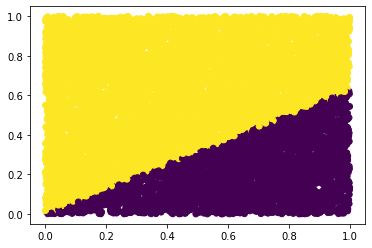

In [833]:
X_x = [np.random.uniform(low=0, high=1) for _ in range(10_000)]
X_y = [np.random.uniform(low=0, high=1) for _ in range(10_000)]
X = np.array([X_x, X_y]).T
Y = [torch.argmax(classify(x, true_phi, true_b)).item() for x in X]
plt.scatter(X_x, X_y, c=Y)

[False False False ...  True  True False]


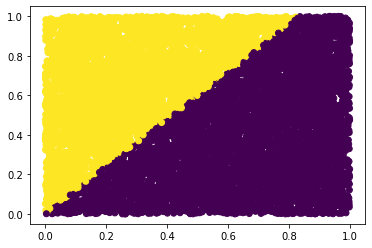

In [20]:
X_x = [np.random.uniform(low=0, high=1) for _ in range(10_000)]
X_y = [np.random.uniform(low=0, high=1) for _ in range(10_000)]
X = np.array([X_x, X_y]).T
W = np.random.rand(2, 2)
print((X @ W)[:,0] > (X @ W)[:,1])
Y = (X @ W)[:,0] > (X @ W)[:,1]
# Y = [torch.argmax(classify(x, true_phi, true_b)).item() for x in X]
plt.scatter(X_x, X_y, c=Y)

C:\Users\Alex\AppData\Local\Temp\ipykernel_39092\828025484.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  reward = u @ softmax(phi @ X_hat + b)


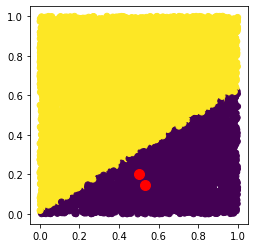

In [861]:
x_new = torch.tensor([0.5, 0.2])
u = torch.tensor([0.3, 0])
x_prime = softmax_gragent(x_new, true_phi, true_b, u).detach()

plt.gca().set_aspect('equal')
plt.scatter(X_x, X_y, c=Y)
plt.plot(x_new[0], x_new[1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.plot(x_prime[0], x_prime[1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")

In [860]:
x_prime

tensor([0.5216, 0.1656])

In [870]:
fake_phi = torch.rand(2,2)
fake_phi.requires_grad_(True)
res = torch.sum(fake_phi + fake_phi[:,1] * 2)
res

tensor(5.3704, grad_fn=<SumBackward0>)

In [871]:
res.backward()

In [878]:
n = 5
Xs = torch.rand((n, d))
W = torch.rand((d, m))

In [886]:
phi @ Xs.T + b.reshape(-1, 1)

tensor([[0.4646, 0.8714, 0.9069, 0.7962, 0.3983],
        [0.3173, 0.5402, 0.5802, 0.4952, 0.2943]])

In [907]:
phi, b = l1norm_phi(Xs, W, u)

tensor([0.3718, 0.3890, 0.3838, 0.3885, 0.3538], grad_fn=<SqueezeBackward3>) tensor([-1.2584, -7.6001, -9.6864, -5.2877, -1.6877], grad_fn=<SubBackward0>)
tensor(-1.8869, grad_fn=<NegBackward0>)
tensor([0.3720, 0.3892, 0.3840, 0.3886, 0.3541], grad_fn=<SqueezeBackward3>) tensor([-1.2577, -7.5999, -9.6846, -5.2874, -1.6868], grad_fn=<SubBackward0>)
tensor(-1.8879, grad_fn=<NegBackward0>)
tensor([0.3722, 0.3893, 0.3842, 0.3888, 0.3544], grad_fn=<SqueezeBackward3>) tensor([-1.2571, -7.5996, -9.6828, -5.2871, -1.6860], grad_fn=<SubBackward0>)
tensor(-1.8889, grad_fn=<NegBackward0>)
tensor([0.3725, 0.3895, 0.3843, 0.3890, 0.3546], grad_fn=<SqueezeBackward3>) tensor([-1.2564, -7.5993, -9.6811, -5.2868, -1.6851], grad_fn=<SubBackward0>)
tensor(-1.8899, grad_fn=<NegBackward0>)
tensor([0.3727, 0.3897, 0.3845, 0.3891, 0.3549], grad_fn=<SqueezeBackward3>) tensor([-1.2557, -7.5990, -9.6793, -5.2865, -1.6842], grad_fn=<SubBackward0>)
tensor(-1.8909, grad_fn=<NegBackward0>)
tensor([0.3730, 0.3898, 0

tensor([0.3942, 0.4045, 0.3994, 0.4046, 0.3800], grad_fn=<SqueezeBackward3>) tensor([-1.1932, -7.5707, -9.5170, -5.2570, -1.5924], grad_fn=<SubBackward0>)
tensor(-1.9827, grad_fn=<NegBackward0>)
tensor([0.3944, 0.4047, 0.3996, 0.4048, 0.3803], grad_fn=<SqueezeBackward3>) tensor([-1.1925, -7.5703, -9.5151, -5.2566, -1.5913], grad_fn=<SubBackward0>)
tensor(-1.9837, grad_fn=<NegBackward0>)
tensor([0.3946, 0.4048, 0.3997, 0.4049, 0.3806], grad_fn=<SqueezeBackward3>) tensor([-1.1917, -7.5699, -9.5133, -5.2562, -1.5902], grad_fn=<SubBackward0>)
tensor(-1.9848, grad_fn=<NegBackward0>)
tensor([0.3949, 0.4050, 0.3999, 0.4051, 0.3809], grad_fn=<SqueezeBackward3>) tensor([-1.1910, -7.5695, -9.5114, -5.2558, -1.5890], grad_fn=<SubBackward0>)
tensor(-1.9858, grad_fn=<NegBackward0>)
tensor([0.3951, 0.4052, 0.4001, 0.4053, 0.3812], grad_fn=<SqueezeBackward3>) tensor([-1.1903, -7.5691, -9.5095, -5.2554, -1.5879], grad_fn=<SubBackward0>)
tensor(-1.9868, grad_fn=<NegBackward0>)
tensor([0.3954, 0.4053, 0

tensor([0.4194, 0.4220, 0.4170, 0.4228, 0.4096], grad_fn=<SqueezeBackward3>) tensor([-1.1139, -7.5170, -9.3121, -5.2056, -1.4702], grad_fn=<SubBackward0>)
tensor(-2.0907, grad_fn=<NegBackward0>)
tensor([0.4196, 0.4222, 0.4171, 0.4230, 0.4098], grad_fn=<SqueezeBackward3>) tensor([-1.1131, -7.5164, -9.3100, -5.2050, -1.4691], grad_fn=<SubBackward0>)
tensor(-2.0917, grad_fn=<NegBackward0>)
tensor([0.4199, 0.4223, 0.4173, 0.4231, 0.4101], grad_fn=<SqueezeBackward3>) tensor([-1.1124, -7.5157, -9.3080, -5.2044, -1.4679], grad_fn=<SubBackward0>)
tensor(-2.0928, grad_fn=<NegBackward0>)
tensor([0.4201, 0.4225, 0.4175, 0.4233, 0.4104], grad_fn=<SqueezeBackward3>) tensor([-1.1116, -7.5151, -9.3059, -5.2038, -1.4667], grad_fn=<SubBackward0>)
tensor(-2.0938, grad_fn=<NegBackward0>)
tensor([0.4204, 0.4227, 0.4176, 0.4235, 0.4107], grad_fn=<SqueezeBackward3>) tensor([-1.1108, -7.5144, -9.3039, -5.2032, -1.4655], grad_fn=<SubBackward0>)
tensor(-2.0949, grad_fn=<NegBackward0>)
tensor([0.4206, 0.4228, 0

In [908]:
X, l1norm_gragent(X, phi, b, u)

(tensor([0.7010, 0.8703]), tensor([0.7077, 0.8481], requires_grad=True))

tensor([0.3850, 0.3733, 0.3764, 0.3736, 0.4035], grad_fn=<SqueezeBackward3>) tensor([-1.2422, -7.3037, -9.4131, -5.0872, -1.6766], grad_fn=<SubBackward0>)
tensor(-1.9118, grad_fn=<NegBackward0>)
tensor([0.3851, 0.3734, 0.3765, 0.3737, 0.4038], grad_fn=<SqueezeBackward3>) tensor([-1.2428, -7.3034, -9.4141, -5.0870, -1.6775], grad_fn=<SubBackward0>)
tensor(-1.9126, grad_fn=<NegBackward0>)
tensor([0.3853, 0.3735, 0.3766, 0.3738, 0.4041], grad_fn=<SqueezeBackward3>) tensor([-1.2435, -7.3030, -9.4152, -5.0869, -1.6783], grad_fn=<SubBackward0>)
tensor(-1.9134, grad_fn=<NegBackward0>)
tensor([0.3855, 0.3736, 0.3767, 0.3740, 0.4044], grad_fn=<SqueezeBackward3>) tensor([-1.2441, -7.3027, -9.4163, -5.0868, -1.6791], grad_fn=<SubBackward0>)
tensor(-1.9142, grad_fn=<NegBackward0>)
tensor([0.3857, 0.3738, 0.3768, 0.3741, 0.4047], grad_fn=<SqueezeBackward3>) tensor([-1.2447, -7.3024, -9.4174, -5.0867, -1.6800], grad_fn=<SubBackward0>)
tensor(-1.9150, grad_fn=<NegBackward0>)
tensor([0.3859, 0.3739, 0

tensor([0.4022, 0.3830, 0.3867, 0.3838, 0.4300], grad_fn=<SqueezeBackward3>) tensor([-1.2958, -7.2720, -9.5111, -5.0751, -1.7160], grad_fn=<SubBackward0>)
tensor(-1.9857, grad_fn=<NegBackward0>)
tensor([0.4024, 0.3831, 0.3868, 0.3839, 0.4303], grad_fn=<SqueezeBackward3>) tensor([-1.2964, -7.2716, -9.5122, -5.0749, -1.7156], grad_fn=<SubBackward0>)
tensor(-1.9865, grad_fn=<NegBackward0>)
tensor([0.4026, 0.3833, 0.3869, 0.3840, 0.4306], grad_fn=<SqueezeBackward3>) tensor([-1.2969, -7.2713, -9.5133, -5.0747, -1.7151], grad_fn=<SubBackward0>)
tensor(-1.9874, grad_fn=<NegBackward0>)
tensor([0.4028, 0.3834, 0.3870, 0.3841, 0.4309], grad_fn=<SqueezeBackward3>) tensor([-1.2975, -7.2709, -9.5144, -5.0746, -1.7146], grad_fn=<SubBackward0>)
tensor(-1.9882, grad_fn=<NegBackward0>)
tensor([0.4030, 0.3835, 0.3871, 0.3842, 0.4312], grad_fn=<SqueezeBackward3>) tensor([-1.2981, -7.2705, -9.5155, -5.0744, -1.7141], grad_fn=<SubBackward0>)
tensor(-1.9891, grad_fn=<NegBackward0>)
tensor([0.4032, 0.3836, 0

tensor([0.4234, 0.3945, 0.3989, 0.3958, 0.4649], grad_fn=<SqueezeBackward3>) tensor([-1.3510, -7.2323, -9.6300, -5.0590, -1.5814], grad_fn=<SubBackward0>)
tensor(-2.0776, grad_fn=<NegBackward0>)
tensor([0.4236, 0.3946, 0.3990, 0.3959, 0.4653], grad_fn=<SqueezeBackward3>) tensor([-1.3515, -7.2319, -9.6312, -5.0589, -1.5798], grad_fn=<SubBackward0>)
tensor(-2.0785, grad_fn=<NegBackward0>)
tensor([0.4238, 0.3947, 0.3991, 0.3961, 0.4657], grad_fn=<SqueezeBackward3>) tensor([-1.3520, -7.2316, -9.6324, -5.0588, -1.5782], grad_fn=<SubBackward0>)
tensor(-2.0794, grad_fn=<NegBackward0>)
tensor([0.4240, 0.3949, 0.3993, 0.3962, 0.4660], grad_fn=<SqueezeBackward3>) tensor([-1.3524, -7.2312, -9.6336, -5.0586, -1.5766], grad_fn=<SubBackward0>)
tensor(-2.0804, grad_fn=<NegBackward0>)
tensor([0.4242, 0.3950, 0.3994, 0.3963, 0.4664], grad_fn=<SqueezeBackward3>) tensor([-1.3529, -7.2308, -9.6348, -5.0585, -1.5751], grad_fn=<SubBackward0>)
tensor(-2.0813, grad_fn=<NegBackward0>)
tensor([0.4245, 0.3951, 0

tensor([0.4463, 0.4063, 0.4115, 0.4082, 0.5079], grad_fn=<SqueezeBackward3>) tensor([-1.3909, -7.1989, -9.7600, -5.0482, -1.4224], grad_fn=<SubBackward0>)
tensor(-2.1802, grad_fn=<NegBackward0>)
tensor([0.4466, 0.4064, 0.4116, 0.4083, 0.5084], grad_fn=<SqueezeBackward3>) tensor([-1.3912, -7.1986, -9.7613, -5.0482, -1.4209], grad_fn=<SubBackward0>)
tensor(-2.1813, grad_fn=<NegBackward0>)
tensor([0.4468, 0.4065, 0.4117, 0.4085, 0.5089], grad_fn=<SqueezeBackward3>) tensor([-1.3914, -7.1984, -9.7626, -5.0481, -1.4194], grad_fn=<SubBackward0>)
tensor(-2.1824, grad_fn=<NegBackward0>)


C:\Users\Alex\AppData\Local\Temp\ipykernel_39092\465945479.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  reward = u @ softmax(phi @ X_hat + b)


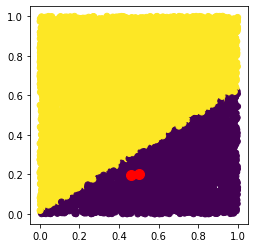

In [910]:
x_new = torch.tensor([0.5, 0.2])
u = torch.tensor([0.3, 0])
phi, b = l1norm_phi(Xs, W, u)
x_prime = softmax_gragent(x_new, phi, b, u).detach()

plt.gca().set_aspect('equal')
plt.scatter(X_x, X_y, c=Y)
plt.plot(x_new[0], x_new[1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.plot(x_prime[0], x_prime[1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")

# Gameplan

- Determine true phi and true b ahead of time, as well as true w and u
- Points randomly sampled from 0-1 both dims
- Every timestep use new point and old points to determine new phi
- No actual learning since we know W, maybe collect a loss for funsies?

In [247]:
def get_xW(X_hat, Rwd, phi, b):
    one_m = torch.ones(m)
    xW = torch.rand(d)
    xW.requires_grad_(True)
    action = (phi @ X_hat + b) / (one_m @ (phi @ X_hat + b))
    optimizer = torch.optim.Adam([xW], lr=0.0001)
    for _ in range(1000):
        optimizer.zero_grad()
        action = (phi @ X_hat + b) / (one_m @ (phi @ X_hat + b))
        loss = (Rwd - xW @ action) ** 2 + (1 - torch.norm(xW)) ** 2
        print(loss.item(), ((Rwd - xW @ action) ** 2).item(), ((1 - torch.norm(xW)) ** 2).item(), action.tolist())
        loss.backward()
        optimizer.step()
    return xW 

def reward(X, Xhat, W, phi, b):
    one_m = torch.ones(m)
    action = (phi @ Xhat + b) / (one_m @ (phi @ Xhat + b))
    return (X @ W) @ action

def opt_phi(Xhats, xWs, u): # no additional penalty for finding x?
    one_m = torch.ones(m)
    phi = torch.rand((m, d))
    phi.requires_grad_(True)
    b = torch.zeros(m)
    # b.requires_grad_(True)
    optimizer = torch.optim.Adam([phi], lr=0.0001)
    relu = nn.ReLU()
    # optimizer = torch.optim.SGD([phi], lr=0.01, momentum=0.9)
    for _ in range(10000):
        optimizer.zero_grad()
        norm_phi = relu(phi) / torch.max(phi) # + torch.rand((m, d)) * 0.05
        actions = (norm_phi @ Xhats.T + b.reshape(-1, 1)) / (one_m @ (norm_phi @ Xhats.T + b.reshape(-1, 1))) # (md @ dn + m) / (m @ (md @ dn + m)) --> mn
        loss = - torch.mean(xWs @ actions) # + (1 - torch.norm(phi)) ** 2 # mean(nm @ mn) --> 1
        # print(torch.mean(xWs @ actions).item(), loss.item())
        loss.backward()
        optimizer.step()
    return (relu(phi) / torch.max(phi)).detach(), b

In [252]:
xW = get_xW(x_prime, rew, phi, b)
xW, rew

0.012271380983293056 0.007384782657027245 0.004886598326265812 [0.0, 1.0]
0.012258635833859444 0.0073676030151546 0.0048910328187048435 [0.0, 1.0]
0.012245921418070793 0.007350453175604343 0.004895468708127737 [0.0, 1.0]
0.01223321445286274 0.007333323825150728 0.004899890627712011 [0.0, 1.0]
0.01222054474055767 0.00731621403247118 0.004904330708086491 [0.0, 1.0]
0.012207907624542713 0.007299134507775307 0.0049087731167674065 [0.0, 1.0]
0.01219528540968895 0.0072820852510631084 0.0049132006242871284 [0.0, 1.0]
0.012182696722447872 0.007265066262334585 0.004917630460113287 [0.0, 1.0]
0.012170139700174332 0.00724807707592845 0.004922062158584595 [0.0, 1.0]
0.01215759664773941 0.007231117691844702 0.004926478955894709 [0.0, 1.0]
0.012145096436142921 0.00721419882029295 0.004930897615849972 [0.0, 1.0]
0.012132611125707626 0.007197309751063585 0.004935301840305328 [0.0, 1.0]
0.012120168656110764 0.007180460728704929 0.004939707927405834 [0.0, 1.0]
0.01210775040090084 0.007163651287555695 0.

0.010030841454863548 0.004784595686942339 0.005246245302259922 [0.0, 1.0]
0.010022949427366257 0.004778224043548107 0.00524472538381815 [0.0, 1.0]
0.01001507043838501 0.004771880805492401 0.005243189167231321 [0.0, 1.0]
0.01000718493014574 0.0047655669040977955 0.005241618026047945 [0.0, 1.0]
0.009999329224228859 0.004759281873703003 0.005240047350525856 [0.0, 1.0]
0.00999146793037653 0.004753025248646736 0.0052384426817297935 [0.0, 1.0]
0.00998361874371767 0.00474679796025157 0.005236820783466101 [0.0, 1.0]
0.009975780732929707 0.004740599077194929 0.0052351816557347775 [0.0, 1.0]
0.009967954829335213 0.004734428599476814 0.005233525764197111 [0.0, 1.0]
0.009960148483514786 0.004728295374661684 0.005231852643191814 [0.0, 1.0]
0.009952335618436337 0.004722190089523792 0.005230145528912544 [0.0, 1.0]
0.009944535791873932 0.004716114141047001 0.005228421650826931 [0.0, 1.0]
0.009936763904988766 0.004710066132247448 0.005226697772741318 [0.0, 1.0]
0.009928986430168152 0.004704046528786421

0.008301124908030033 0.003756584133952856 0.004544540774077177 [0.0, 1.0]
0.008294950239360332 0.0037536548916250467 0.004541295114904642 [0.0, 1.0]
0.008288783952593803 0.003750734031200409 0.0045380499213933945 [0.0, 1.0]
0.008282620459794998 0.0037478143349289894 0.004534806124866009 [0.0, 1.0]
0.008276466280221939 0.0037449030205607414 0.004531563725322485 [0.0, 1.0]
0.008270314894616604 0.003741992637515068 0.004528322257101536 [0.0, 1.0]
0.00826414953917265 0.0037390836514532566 0.004525065887719393 [0.0, 1.0]
0.008258026093244553 0.0037361830472946167 0.004521842580288649 [0.0, 1.0]
0.008251888677477837 0.003733283607289195 0.004518604837357998 [0.0, 1.0]
0.008245744742453098 0.003730392549186945 0.004515352193266153 [0.0, 1.0]
0.008239618502557278 0.0037275024224072695 0.004512116312980652 [0.0, 1.0]
0.008233502507209778 0.003724620910361409 0.004508881829679012 [0.0, 1.0]
0.008227389305830002 0.003721740562468767 0.004505648743361235 [0.0, 1.0]
0.008221277967095375 0.003718861

0.006881802808493376 0.003111806698143482 0.0037699961103498936 [0.0, 1.0]
0.006876794621348381 0.0031095794402062893 0.0037672151811420918 [0.0, 1.0]
0.0068717882968485355 0.0031073528807610273 0.003764435416087508 [0.0, 1.0]
0.006866775453090668 0.0031051337718963623 0.003761641914024949 [0.0, 1.0]
0.0068617938086390495 0.0031029153615236282 0.003758878679946065 [0.0, 1.0]
0.006856800056993961 0.0031006978824734688 0.003756101941689849 [0.0, 1.0]
0.006851807236671448 0.003098481334745884 0.0037533261347562075 [0.0, 1.0]
0.006846816744655371 0.0030962652526795864 0.0037505514919757843 [0.0, 1.0]
0.0068418425507843494 0.0030940501019358635 0.003747792448848486 [0.0, 1.0]
0.006836862303316593 0.0030918424017727375 0.003745019668713212 [0.0, 1.0]
0.006831883452832699 0.003089635632932186 0.0037422480527311563 [0.0, 1.0]
0.006826906464993954 0.003087429329752922 0.0037394773680716753 [0.0, 1.0]
0.006821946240961552 0.0030852241907268763 0.003736722283065319 [0.0, 1.0]
0.006816987879574299

0.0057312180288136005 0.0026032377500087023 0.0031279802788048983 [0.0, 1.0]
0.005727093201130629 0.0026014193426817656 0.003125673858448863 [0.0, 1.0]
0.0057229893282055855 0.0025996079202741385 0.0031233816407620907 [0.0, 1.0]
0.00571887381374836 0.0025977969635277987 0.003121076850220561 [0.0, 1.0]
0.005714759696274996 0.00259598670527339 0.003118772991001606 [0.0, 1.0]
0.005710660479962826 0.0025941769126802683 0.003116483334451914 [0.0, 1.0]
0.0057065486907958984 0.0025923678185790777 0.0031141811050474644 [0.0, 1.0]
0.0057024527341127396 0.002590559422969818 0.003111893078312278 [0.0, 1.0]
0.005698357708752155 0.0025887517258524895 0.003109605982899666 [0.0, 1.0]
0.005694264080375433 0.002586944494396448 0.003107319585978985 [0.0, 1.0]
0.0056901779025793076 0.0025851440150290728 0.0031050341203808784 [0.0, 1.0]
0.0056860800832509995 0.0025833442341536283 0.0031027360819280148 [0.0, 1.0]
0.005681997165083885 0.0025815449189394712 0.003100452246144414 [0.0, 1.0]
0.00567791564390063

(tensor([0.4764, 0.9420], requires_grad=True), tensor(0.9927))

In [254]:
a = phi @ x_prime / (one_m @ (phi @ x_prime))
x_new @ W, a, (x_new @ W) @ a, xW @ a, (rew - xW @ a) ** 2

(tensor([0.9927, 1.1150]),
 tensor([0., 1.]),
 tensor(1.1150),
 tensor(0.9420, grad_fn=<DotBackward0>),
 tensor(0.0026, grad_fn=<PowBackward0>))

In [186]:
X_x = [np.random.uniform(low=0, high=1) for _ in range(10_000)]
X_y = [np.random.uniform(low=0, high=1) for _ in range(10_000)]
X = torch.tensor(np.array([X_x, X_y]).T, dtype=torch.float32)
W = torch.rand((2, 2))

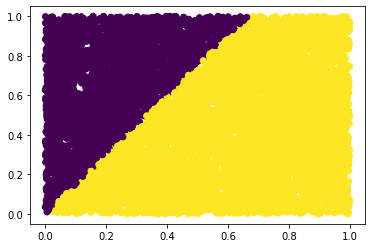

In [255]:
Y = (X @ W)[:,0] > (X @ W)[:,1]
plt.scatter(X_x, X_y, c=Y)

In [256]:
W

tensor([[0.8385, 0.5451],
        [0.7961, 0.9919]])

In [86]:
phi = opt_phi(X, X @ W, torch.zeros(m))

In [222]:
m = 2 # number of actions
d = 2 # number of dimensions
dataset = []
adv_dataset = []
labels = []
true_phi = torch.rand((m, d))
true_b = torch.zeros(m)
# u = torch.rand(m)
# W = torch.rand((d, m))
one_m = torch.ones(m)
phi = torch.rand((m, d))
b = torch.zeros(m)

x_new = torch.rand(d)
x_prime = l1norm_gragent(x_new, phi, b, u).detach()
dataset.append(x_new)
adv_dataset.append(x_prime)
rew = reward(x_new, x_prime, W, phi, b).detach()
xW = get_xW(x_prime, rew, phi, b).detach()
labels.append(xW)

Xhats = torch.stack(adv_dataset)
xWs = torch.stack(labels)
Xs = torch.stack(dataset)

In [232]:
xW_true = Xhats @ W
print('xWs: ', xW_true.tolist())
relu = nn.ReLU()
phi, b = opt_phi(Xhats, xW_true, None)
# nphi = relu(phi) / torch.max(phi)
print('Phi: ', phi.tolist())
print('Xhat:', Xhats.tolist())
clf = phi @ Xhats.T / (torch.ones(m) @ (phi @ Xhats.T))
print('Clf: ', clf.tolist()) # action
print('Rew: ', (xW_true @ clf)[:,0].tolist())

xWs:  [[0.776593804359436, 0.7279911041259766], [1.3853859901428223, 1.3658171892166138], [0.765604555606842, 0.8181165456771851], [1.142574667930603, 1.0694520473480225], [0.6457672119140625, 0.8045029044151306], [1.357229471206665, 1.3206204175949097]]
Phi:  [[0.0, 0.0], [0.7253062129020691, 1.0]]
Xhat: [[0.47946423292160034, 0.4704628884792328], [0.7209693789482117, 0.9807912111282349], [0.271691232919693, 0.675505518913269], [0.7086511254310608, 0.6887703537940979], [0.00012470535875763744, 0.8110173940658569], [0.7412154674530029, 0.924098551273346]]
Clf:  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
Rew:  [0.7279911041259766, 1.3658171892166138, 0.8181165456771851, 1.0694520473480225, 0.8045029044151306, 1.3206204175949097]


In [221]:
phi @ Xhats[0]

tensor([1.6797, 0.0000])

In [228]:
x_new = torch.rand(d)
Xhats = torch.stack(adv_dataset)
xWs = torch.stack(labels)
Xs = torch.stack(dataset)
phi, b = opt_phi(Xhats, xWs, u)
phi = phi.detach()

x_prime = l1norm_gragent(x_new, phi, b, u).detach()
dataset.append(x_new)
adv_dataset.append(x_prime)
rew = reward(x_new, x_prime, W, phi, b).detach()
xW = get_xW(x_prime, rew, phi, b).detach()
labels.append(xW)

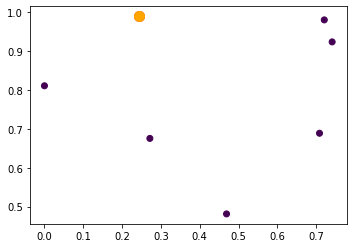

In [229]:
actions = torch.max(phi @ Xs.T + b.reshape(-1, 1) / (one_m @ (phi @ Xs.T + b.reshape(-1, 1))), axis=0)

plt.gca().set_aspect('equal')
plt.scatter(Xs[:, 0], Xs[:, 1], c=actions.indices.tolist())
plt.plot(x_new[0], x_new[1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.plot(x_prime[0], x_prime[1], marker="o", markersize=10, markeredgecolor="orange", markerfacecolor="orange")

In [969]:
x_new = torch.rand(d)
Xs = torch.stack(dataset)
phi, b = l1norm_phi(Xs, W, u)
x_prime = l1norm_gragent(x_new, phi, b, u).detach()
dataset.append(x_prime)

In [947]:
phi, Xs, phi @ Xs.T / (one_m @ (phi @ Xs.T))

(tensor([[0.2062, 0.1774],
         [0.8851, 0.7943]], requires_grad=True),
 tensor([[0.5000, 0.5000]]),
 tensor([[0.1859],
         [0.8141]], grad_fn=<DivBackward0>))

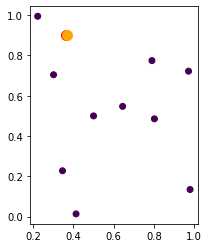

In [970]:
actions = torch.max(phi @ Xs.T / (one_m @ (phi @ Xs.T)), axis=0)
# print(actions.indices.tolist())
plt.gca().set_aspect('equal')
plt.scatter(Xs[:, 0], Xs[:, 1], c=actions.indices.tolist())
plt.plot(x_new[0], x_new[1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.plot(x_prime[0], x_prime[1], marker="o", markersize=10, markeredgecolor="orange", markerfacecolor="orange")